<a href="https://colab.research.google.com/github/lostapple9/CovidLungDetectionModel/blob/lostapple9-patch-1/CovidLungDetectionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import gc
import random
import matplotlib.pyplot as plt
import numpy as np
from cv2 import resize, imread, IMREAD_COLOR, IMREAD_GRAYSCALE, INTER_CUBIC
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

covid_set = ['/content/drive/MyDrive/covid19_lung_data/{}'.format(i) for i in os.listdir('/content/drive/MyDrive/covid19_lung_data')]
normal_set = ['/content/drive/MyDrive/normal_lung_data/{}'.format(i) for i in os.listdir('/content/drive/MyDrive/normal_lung_data')]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
print(normal_set)
print(covid_set)

['/content/drive/MyDrive/normal_lung_data/Normal-10.png', '/content/drive/MyDrive/normal_lung_data/Normal-100.png', '/content/drive/MyDrive/normal_lung_data/Normal-1.png', '/content/drive/MyDrive/normal_lung_data/Normal-101.png', '/content/drive/MyDrive/normal_lung_data/Normal-103.png', '/content/drive/MyDrive/normal_lung_data/Normal-105.png', '/content/drive/MyDrive/normal_lung_data/Normal-106.png', '/content/drive/MyDrive/normal_lung_data/Normal-104.png', '/content/drive/MyDrive/normal_lung_data/Normal-102.png', '/content/drive/MyDrive/normal_lung_data/Normal-107.png', '/content/drive/MyDrive/normal_lung_data/Normal-111.png', '/content/drive/MyDrive/normal_lung_data/Normal-115.png', '/content/drive/MyDrive/normal_lung_data/Normal-108.png', '/content/drive/MyDrive/normal_lung_data/Normal-114.png', '/content/drive/MyDrive/normal_lung_data/Normal-112.png', '/content/drive/MyDrive/normal_lung_data/Normal-113.png', '/content/drive/MyDrive/normal_lung_data/Normal-109.png', '/content/drive/

In [4]:
total = normal_set + covid_set
random.shuffle(total)

In [5]:
split = 0.8
slice_reserve = 10;
slice_total = len(normal_set)
slice_list_max = slice_total - slice_reserve
slice_list = int(slice_list_max*split)

train_set = total[:slice_list]
test_set = total[slice_list: slice_list_max]
reserve_set = total[slice_list_max: slice_total]


In [6]:

del covid_set,normal_set
gc.collect()

262

In [7]:
width = 250
height = 250



In [8]:
X_train = []
X_test = []
X_reserve = []

y_train = []
y_test = []
y_reserve = []


In [9]:
# a 0 label indicates positive covid pneumonia
# a 1 label indicates no pneumonia
def preprocess_image_set(data_set):
  X_set = []
  y_set = []
  for image in data_set:
    try:
      X_set.append(resize(imread(image), (width, height), interpolation = INTER_CUBIC))
      if 'COVID-' in image:
        y_set.append(0)
      else:
        y_set.append(1)
    except Exception:
      print('failed to format: ', image)
  return X_set, y_set

In [10]:
def show_images(image_set, label_set):
  plt.figure(figsize = (10,10))
  for i in range(9):
    ax = plt.subplot(3,3, i + 1)
    plt.imshow(image_set[i])
    plt.title(label_set[i])
    plt.axis("off")


In [11]:
X_train, y_train = preprocess_image_set(train_set)

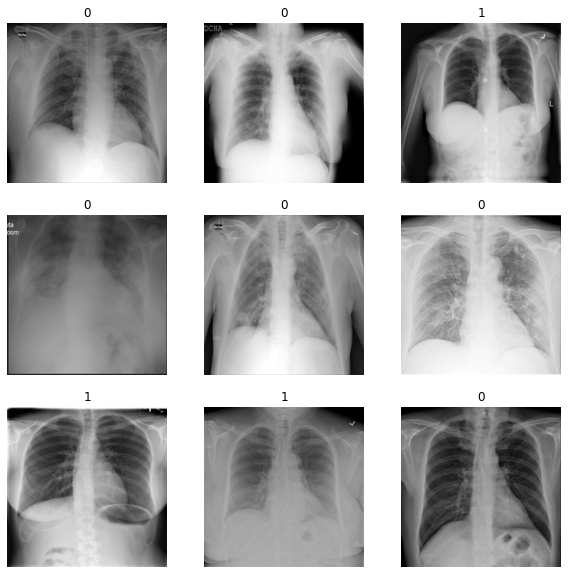

In [12]:
# show the first 10 images from training set
# 1 = no covid, 0 = has covid
show_images(X_train, y_train)

In [13]:
X_test, y_test = preprocess_image_set(test_set)

In [14]:
X_reserve, y_reserve = preprocess_image_set(reserve_set)

In [15]:
del train_set, test_set, reserve_set
gc.collect()

18158

In [16]:
# translate lists into numpy arrays
X_train =  np.array(X_train)
X_test = np.array(X_test)
X_reserve =  np.array(X_reserve)

y_train = np.array(y_train)
y_test = np.array(y_test)


In [17]:

model = Sequential()
model.add(Conv2D(32, kernel_size = 3, activation = 'relu', input_shape = (width, height,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, kernel_size = 3, activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, kernel_size = 3, activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(256, kernel_size = 3, activation = 'relu'))
model.add(Flatten())
#model.add(Dropout(0.5))
model.add(Dense(600, activation = 'relu'))
model.add(Dense(200, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [18]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 256)       2

In [19]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [20]:
history = model.fit(X_train,y_train, validation_data = (X_test, y_test), epochs = 15)

Epoch 1/15
5/5 [==============================] - 30s 6s/step - loss: 610.0933 - accuracy: 0.5000 - val_loss: 35.8846 - val_accuracy: 0.4737
Epoch 2/15
5/5 [==============================] - 27s 5s/step - loss: 12.9214 - accuracy: 0.5132 - val_loss: 0.5316 - val_accuracy: 0.7632
Epoch 3/15
5/5 [==============================] - 28s 6s/step - loss: 2.5242 - accuracy: 0.6447 - val_loss: 0.5763 - val_accuracy: 0.6842
Epoch 4/15
5/5 [==============================] - 28s 6s/step - loss: 1.5041 - accuracy: 0.5329 - val_loss: 4.6830 - val_accuracy: 0.5263
Epoch 5/15
5/5 [==============================] - 27s 5s/step - loss: 1.7648 - accuracy: 0.5789 - val_loss: 0.6041 - val_accuracy: 0.7368
Epoch 6/15
5/5 [==============================] - 28s 6s/step - loss: 0.6588 - accuracy: 0.7500 - val_loss: 0.4520 - val_accuracy: 0.8158
Epoch 7/15
5/5 [==============================] - 28s 6s/step - loss: 0.4489 - accuracy: 0.7961 - val_loss: 0.4914 - val_accuracy: 0.8684
Epoch 8/15
5/5 [==============

In [21]:
history.history['accuracy']

[0.5,
 0.5131579041481018,
 0.6447368264198303,
 0.5328947305679321,
 0.5789473652839661,
 0.75,
 0.7960526347160339,
 0.7565789222717285,
 0.8421052694320679,
 0.8684210777282715,
 0.8947368264198303,
 0.9473684430122375,
 0.8026315569877625,
 0.8355262875556946,
 0.8486841917037964]

In [22]:
# make label predictions on unseen data
y_predict = model.predict(X_reserve[:slice_reserve])
y_pred = (y_predict > 0.5)

In [23]:
y_pred = y_pred.tolist()

In [24]:
y_predict = y_predict.tolist()
y_predict

[[0.012892007827758789],
 [0.028346896171569824],
 [0.9998712539672852],
 [0.9958211183547974],
 [0.9999995231628418],
 [0.5714382529258728],
 [0.05800396203994751],
 [0.9999992251396179],
 [0.002015411853790283],
 [0.02156960964202881]]

In [25]:
y_reserve

[0, 0, 1, 1, 1, 0, 0, 0, 0, 0]

In [26]:
for i in range(len(y_predict)):
  print("predicted result: %0.5f percent probability does not have covid" % (y_predict[i][0]*100))
  if(y_reserve[i] == 0):
    print("Actual result: has covid")
  else:
    print("Actual result: does not have covid")
  print()


predicted result: 1.28920 percent probability does not have covid
Actual result: has covid

predicted result: 2.83469 percent probability does not have covid
Actual result: has covid

predicted result: 99.98713 percent probability does not have covid
Actual result: does not have covid

predicted result: 99.58211 percent probability does not have covid
Actual result: does not have covid

predicted result: 99.99995 percent probability does not have covid
Actual result: does not have covid

predicted result: 57.14383 percent probability does not have covid
Actual result: has covid

predicted result: 5.80040 percent probability does not have covid
Actual result: has covid

predicted result: 99.99992 percent probability does not have covid
Actual result: has covid

predicted result: 0.20154 percent probability does not have covid
Actual result: has covid

predicted result: 2.15696 percent probability does not have covid
Actual result: has covid



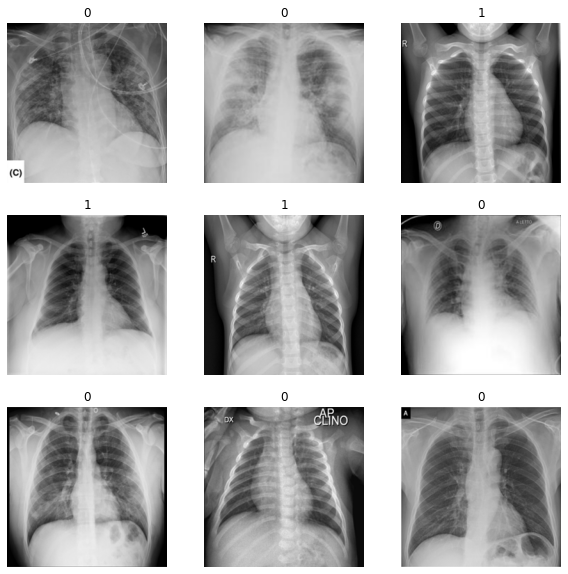

In [27]:
# show the images from reserve set
# 1 = no covid, 0 = covid

show_images(X_reserve, y_reserve)


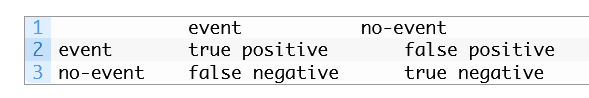


In [28]:
from sklearn.metrics import confusion_matrix

#event = has covid
#no-event = does not have covid
model_metric = confusion_matrix(y_reserve, y_pred)

In [29]:
accuracy = (model_metric[0][0] + model_metric[1][1])/ (sum(map(sum, model_metric)))
accuracy

0.8